<a href="https://colab.research.google.com/github/destsummer/Bioinformatics-Student-Portfolio/blob/master/WordEmbeddings_Autoencoder_DeepLearningGenomics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: K-mer Embeddings with Autoencoders - Deep Learning in Genomics Primer (*Tutorial*)

In this homework we will encode DNA sequences not directly nucleotide-by-nucleotide but instead by defining words and encoding a dictionary of same length sequence fragments ("k-mers"). 


This tutorial is based  on the supplement to the manuscript, **A Primer on Deep Learning in Genomics** (*Nature Genetics, 2018*) by James Zou, Mikael Huss, Abubakar Abid, Pejman Mohammadi, Ali Torkamani & Amalio Telentil. [Read the accompanying paper here](https://www.nature.com/articles/s41588-018-0295-5).


## Instructions

1. Create a local copy of this notebook with File->Save a copy in Drive
2. Read the document and the code cells. Whereever you find YOUR CODE GOES HERE in the code, change it accordingly. Make changes in the order they appear in the code. Initial versions of the code will create error messages. That is OK as long as the error messages appear in code cells that appear later than the part of the code you are currently working on.
3. Iterate through point 2. until the model can be trained and evaluated without error messages. Compute the accuracy of the model.
4. Once this part of the code works, we want to find out which word lengths and which number of autoencoder dimensions (implemented as Keras layer called `Embedding`) is optimal. Vary both variables `wordlen` and `targetdim` to have values 2,3,4 leading to 9 different combinations. Compute accuracies for each of these 9 different values by using Runtime->Restart and Run all.  Enter these values manually in the table provided at the end of this document. Which combination is optimal? Slight variations due to random number seed effects are OK.

## How to Use This Tutorial 

This tutorial utilizes a Colab notebook , which is an interactive computational enviroment that combines live code, visualizations, and explanatory text. To run this notebook, you may first need to make a copy by choosing **File > Save a Copy in Drive** from the menu bar (may take a few moments to save).

The notebook is organized into a series of cells. You can modify the Python command and execute each cell as you would a Jupyter notebook. To run all of the cells at once, choose **Runtime > Run all** from the menu bar.

## 0. Background

In this tutorial, we will show how to use deep learning to approach an important problem in functional genomics: **the discovery of transcription-factor binding sites in DNA**.

As we go through this notebook, we will  design a neural network that can discover binding motifs in DNA based on the results of an assay that determines whether a longer DNA sequence binds to the protein or not. Here, the longer DNA sequences are our *independent variables* (or *predictors*), while the positive or negative response of the assay is the *dependent variable* (or *response*).

We will use simulated data that consists of DNA sequences of length 50 bases (chosen to be artificially short so that the data is easy to play around with), and is labeled with 0 or 1 depending on the result of the assay. Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein and discover the short motif that is the binding site in the sequences that are bound to the protein.

(Spoiler alert: the true regulatory motif is *`CGACCGAACTCC`*. Of course, the neural network doesn't know this.)


## 1. Curate the Data

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-01.png?raw=true)

As in previous versions of this tutorial, we start by loading the data. Also, we will define an encoding for same-length words.

We start by loading the simulated data from an external repository.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

alphabet = ('A','C','G','T')
nalpha = len(alphabet)
seqlen = 50 # character sequence lengths DO NOT CHANGE

# wordlen and targetdim MAY BE CHANGED ONCE YOUR CODE RUNS WITHOUT ERRORS: 
wordlen = 2 # length of consecutive characters/integers used as "word"
targetdim = 2 # number of dimensions used by Embedding layer

numwords = nalpha ^ wordlen # YOUR CODE GOES HERE: number of diff. words = size of dictionary

# HOW MANY WORDS OF LENGTH wordlen FIT INTO SEQUENCE OF LENGTH seqlen?
inputlen = int(seqlen/wordlen) # YOUR CODE GOES HERE: number of integer sequences fed to model

def my_integer_encode(s):
    ary = np.zeros((len(s),1))
    for i in range(0,len(s)):
        code = 0
        if s[i] == 'A':
            code = 0
        elif s[i] == 'C':
            code = 1
        elif s[i] == 'G':
            code = 2
        elif s[i] == 'T':
            code = 3
        else:
            warnings.warn("Bad sequence character at position ",(i+1),":",s[i],":",s)
        ary[i,0] = code
    return ary         


def my_wordindex_encode(v,wlen,base):
    '''for a vector of integers, return array of hashes corresponding to
       overlapping words of length wlen:
       
       Parameters:
       v: input vector: DNA sequence encoded as numbers 0,1,2,3
       wlen: number of digits (=nucleotides) of each word
       base: number of character codes - in case of DNA or RNA set base to 4
       
       Returns: Array with hash codes of each word
    '''
    na = inputlen # YOUR CODE GOES HERE: MAXIMUM INDEX (EXCLUSIVE) OF FIRST DIGIT OF 
            # WORD SO THAT WHOLE WORD IT FITS INTO VECTOR V
            # SAME AS NUMBER OF OVERLAPPING WORDS THAT FIT INTO v
    ary = np.zeros((na,1))
    for i in range(0,na):
        x = 0 # WILL BE HASH CODE CORRESPONDING TO WORD
        for j in range(0,wlen):
           p = wlen - j - 1
           x += v[j] * (4^p) # YOUR CODE GOES HERE
           ary[i] = x
    return ary
      
SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()

,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


The next  step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, tensors). 

To get each DNA sequence in the form of a matrix, we use _one-hot encoding_, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix. 

In the cell below, we encode the simulated DNA sequences using integers that represent dictionary indices of words (k-mers):

In [0]:
%%capture
# warnings are supppressed

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

input_features = np.zeros((len(sequences),inputlen))

for i,sequence in enumerate(sequences):
  # encode A,C,G,T as 0,1,2,3:
  integer_encoded = my_integer_encode(sequence) # turn A,C,G,T to 0,1,2,3
  # create integers for consecutive sets of integer indices
  integer_encoded = my_wordindex_encode(integer_encoded, wordlen, nalpha) # hashes
  # change shape to variable number of rows, 1 column:
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  for j in range(0,integer_encoded.shape[0]):
      input_features[i,j] = integer_encoded[j]

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)

Some debug output:

In [0]:
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',len(sequences[0]), input_features[0].shape,':',
      input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 50 (25,) : [9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9.]


Similarly, we can go ahead and load the labels (_response variables_). In this case, the labels are structured as follows: a "1" indicates that a protein bound to the sequence, while a "0" indicates that the protein did not. While we could use the labels as a vector, it is often easier to similarly one-hot encode the labels, as we did the features. We carry out that here:

In [0]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(n_values=2)
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:331: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)]'.
  warnings.warn(msg, DeprecationWarning)


Here are some technicalities that you can skip over related to random number seeds:

In [0]:
# DO NOT CHANGE THIS CODE
# SKIP READING CODE TO NEXT CODE CELL

seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


We also go ahead and split the data into training and test sets. The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training. At a later step, we will further partition the training set into a training and validation set.

In [0]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)

## 2. Select the Architecture and Train

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-49.png?raw=true)

Next, we choose a neural network architecture to train the model. In this tutorial, we choose a simple 1D convolutional neural network (CNN), which is commonly used in deep learning for functional genomics applications.

A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In our dataset, the filters will be motifs within the DNA sequences. The CNN may then learn to combine these filters to recognize a larger structure (e.g. the presence or absence of a transcription factor binding site). 

We will use the deep learning library `Keras`. As of 2017, `Keras` has been integrated into `TensorFlow`,  which makes it very easy to construct neural networks. We only need to specify the kinds of layers we would like to include in our network, and the dimensionality of each layer. The CNN we generate in this example consists of the following layers:

- _Conv1D_: We define our convolutional layer to have 32 filters of size 12 bases.

- _MaxPooling1D_: After the convolution, we use a pooling layer to down-sample the output of the each of the 32 convolutional filters. Though not always required, this is a typical form of non-linear down-sampling used in CNNs.

- _Flatten_: This layer flattens the output of the max pooling layer, combining the results of the convolution and pooling layers across all 32 filters. 

- _Dense_: The first Dense tensor creates a layer (dense_1) that compresses the representation of the flattened layer, resulting in smaller layer with 16 tensors, and the second Dense function converges the tensors into the output layer (dense_2) that consists of the two possible response values (0 or 1).

We can see the details of the architecture of the neural network we have created by running `model.summary()`, which prints the dimensionality and number of parameters for each layer in our network. 

In [0]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten,Embedding
from tensorflow.keras.models import Sequential
print("train_features.shape:",train_features.shape)
model = Sequential()
# Add Embedding layer that encodes our dictionary codes in targetdim dimensions:
# Hint: Embedding needs 3 arguments: number of possible input codes, 
# number of target dimensions and "input_length" set to number of integer codes
# that correspond to one case (in our example one DNA sequence)
# model.add(Embedding(...)) # YOUR CODE GOES HERE
model.add(Embedding(numwords, targetdim, input_length=inputlen))
model.add(Conv1D(filters=32, kernel_size=12 ) )
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()

train_features.shape: (1500, 25)
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 2)             12        
_________________________________________________________________
conv1d (Conv1D)              (None, 14, 32)            800       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                1552      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 2,398
Trainable params:

Now, we are ready to go ahead and train the neural network. We will further divide the training set into a training and validation set. We will train only on the reduced training set, but plot the loss curve on both the training and validation sets. Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.

Train on 1125 samples, validate on 375 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1125/1125 [==============================] - 2s 2ms/sample - loss: 0.6938 - binary_accuracy: 0.4813 - val_loss: 0.6930 - val_binary_accuracy: 0.5200
Epoch 2/50
1125/1125 [==============================] - 0s 134us/sample - loss: 0.6934 - binary_accuracy: 0.4942 - val_loss: 0.6931 - val_binary_accuracy: 0.5253
Epoch 3/50
1125/1125 [==============================] - 0s 125us/sample - loss: 0.6934 - binary_accuracy: 0.4720 - val_loss: 0.6935 - val_binary_accuracy: 0.4533
Epoch 4/50
1125/1125 [==============================] - 0s 124us/sample - loss: 0.6931 - binary_accuracy: 0.4747 - val_loss: 0.6937 - val_binary_accuracy: 0.4587
Epoch 5/50
1125/1125 [==============================] - 0s 125us/sample - loss: 0.6934 - binary_accuracy: 0.4933 - val_loss: 0.6937 - val_binary_accuracy: 0.5253
Epoch 6/50
1125/1125 [==============================] - 0s 125us/sample - loss: 0.6931 - binary_a

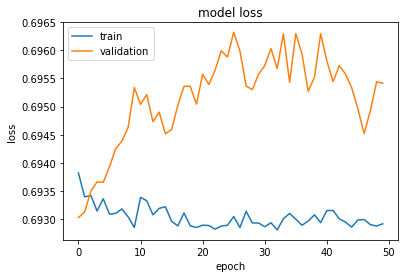

In [0]:
history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=1, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Similarly, we can plot the accuracy of our neural network on the binary classification task. The metric used in this example is the _binary accuracy_, which calculates the proportion of predictions that match labels or response variables. Other metrics may be used in different tasks -- for example, the _mean squared error_ is typically used to measure the accuracy for continuous response variables (e.g. polygenic risk scores, total serum cholesterol level, height, weight and systolic blood pressure).

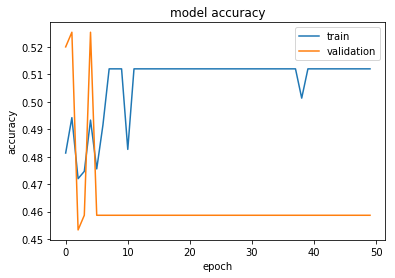

In [0]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## 3. Evaluate

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-12.png?raw=true)

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, we evaluate the model on the test set and plot the results as a confusion matrix. Nearly every test sequence should be correctly classified.

Confusion matrix:
 [[ 32 227]
 [ 30 211]]


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


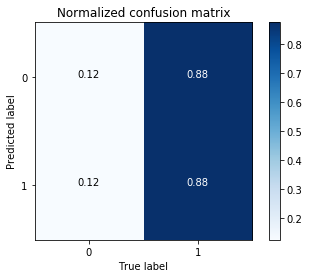

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

## Compute accuracy value



In [0]:
accuracy = (32+211)/ (32+211+227+30) # YOUR CODE GOES HERE
print("The accuracy is ", 100*accuracy,"%")

The accuracy is  48.6 %


# Optimize Word Length and Target Dimensions

Enter manually 9 accuracy values for different values of `targetdim` (columns) and `wordlen` (rows):


|---| 2 | 3 | 4 |
|---|---|---|----|
|2 | 9  | 9 | 9 |
|3 | 19  | 19 | 19 |
|4 | 23 | 23 | 23 |

